In [1]:
import util
import numpy as np
results = util.calcResults( ["results/out8.json"], True)

/home/mojashi/.anyenv/envs/pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


results/out8.json 10 8 1-10-1 10-100-5 10-100-5 0-50-5 


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
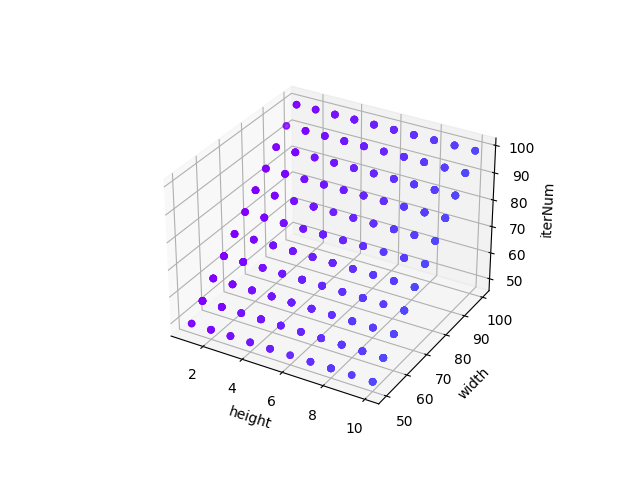

In [15]:
%matplotlib widget
obj = "iterNum"

import matplotlib.pyplot as plt
import matplotlib.cm as cm 

colors = cm.rainbow(np.linspace(0, 1, np.max(results['height'])))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xax="processNum"
yax="height"

ax.set_xlabel(xax)
ax.set_ylabel(yax)
ax.set_zlabel(obj)
target = results[(results['obstacleRatio']==0) &(results['width']==50) &  (results['neighborsNum']==8)].sample(1000)
ax.scatter3D(xs=target['processNum'], ys=target['height'] ,zs=target[obj], c=colors[target['processNum']-1])

In [3]:
results[(results['neighborsNum']==8) & (results["obstacleRatio"]==0)]

,processNum,height,width,obstacleRatio,neighborsNum,iterNum,MAXPQSize
0,1,10,10,0.0,8,9,31
1,1,10,10,0.0,8,9,31
2,1,10,10,0.0,8,9,31
3,1,10,10,0.0,8,9,31
4,1,10,10,0.0,8,9,31
...,...,...,...,...,...,...,...
396995,10,100,100,0.0,8,99,72
396996,10,100,100,0.0,8,99,74
396997,10,100,100,0.0,8,99,72
396998,10,100,100,0.0,8,99,76


In [4]:
import pandas as pd
from operator import mul
from functools import reduce

obj = "MAXPQSize"
results8 = results[results['neighborsNum']==8]

terms = [
    "width*height", 
    # "width", 
    "height", 
    # "processNum",
    "width*1/processNum",
    "height*1/processNum",
    # "obstacleRatio*width*height", 
    "obstacleRatio*width*height*1/processNum",
]

columns = []
for term in terms:
    col = np.ones_like(results["width"])
    columns.append(pd.DataFrame(reduce(mul ,
        map(lambda label: 1/np.array(results8[label[2:]]) if label.startswith("1/") else np.array(results8[label]), term.split("*"))),
         columns=[term]))

df = pd.concat(columns, axis=1)
# for i in df.columns:
#     df[i] = (df[i] - df[i].mean()) / (df[i].max() - df[i].min())

from sklearn import linear_model
clf = linear_model.LinearRegression(fit_intercept=False)

model = clf.fit(df, results8[obj])
err = abs(model.predict(df) - results8[obj])
print(np.average(err))
print(np.median(err))
print(model.intercept_)
print(pd.DataFrame(zip(model.coef_, df.columns)).sort_values(by=0, ascending=False))

# (2.367124*width + 0.950211*height - 0.055066*obstacleRatio*width*height)/processNum + 0.213089*height + 0.003213*width*height

7.795291462934153
5.919483597851993
0.0
          0                                        1
2  2.367124                       width*1/processNum
3  0.950211                      height*1/processNum
1  0.213089                                   height
0  0.003213                             width*height
4 -0.055066  obstacleRatio*width*height*1/processNum


In [11]:
import pandas as pd
from operator import mul
from functools import reduce

obj = "iterNum"
results8 = results[(results['neighborsNum']==8) ]
results8 = results8[set(results8.columns)]

terms = [
    # "height", 
    "width*1/processNum",
    # "width*height", 
    "obstacleRatio*1/processNum",
    # "height*1/width",
    # "width", 
    # "processNum",
    # "width*processNum", 
    # "height*processNum", 
    # "processNum*processNum",
    # "obstacleRatio*width*height", 
    # "height*1/processNum",
]

columns = []
columns.append(pd.DataFrame(np.array(results["height"]) - 1, columns=["height-1"]))
for term in terms:
    col = np.ones_like(results["width"])
    columns.append(pd.DataFrame(reduce(mul ,
        map(lambda label: 1/np.array(results8[label[2:]]) if label.startswith("1/") else np.array(results8[label]), term.split("*"))),
         columns=[term]))

df = pd.concat(columns, axis=1)
# for i in df.columns:
#     df[i] = (df[i] - df[i].mean()) / (df[i].max() - df[i].min())

from sklearn import linear_model
clf = linear_model.HuberRegressor(fit_intercept=False)
# clf = linear_model.LinearRegression(fit_intercept=False)

model = clf.fit(df, results8[obj])
err = abs(model.predict(df) - results8[obj])/results8[obj]
print(np.average(err))
print(np.median(err))
print(model.intercept_)
print(pd.DataFrame(zip(model.coef_, df.columns)).sort_values(by=0, ascending=False))

# (height - 1) * 1.04 + (0.059319 * obstacleRatio*width*height - 0.331970*width)/processNum 

0.13394683314737985
0.06391265076660577
0.0
            0                           1
2  218.407212  obstacleRatio*1/processNum
0    1.021800                    height-1
1   -0.168277          width*1/processNum
